In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [2]:
dataset_path = "./PlantVillage"  

img_size = 224
batch_size = 32

print(f"Dataset Path Set: {dataset_path}")
print(f"Image Size: {img_size}x{img_size}, Batch Size: {batch_size}")

Dataset Path Set: ./PlantVillage
Image Size: 224x224, Batch Size: 32


In [3]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training Data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Validation Data
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Print classes to verify
print("Classes found:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
print(f"Number of Classes: {num_classes}")

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Classes found: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}
Number of Classes: 15


In [16]:
# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3),include_top=False,weights='imagenet')
base_model.trainable = False  # Freeze all layers initially
print("Base model loaded and frozen.")

Base model loaded and frozen.


In [17]:
# Custom Model on top of MobileNetV2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled successfully.")

Model compiled successfully.


In [8]:
# Make directory for saving models if not exists
os.makedirs("saved_models", exist_ok=True)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    'saved_models/mobilenet_finetuned_best.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

print("\nCallbacks for early stopping and model checkpointing are set.")


Callbacks for early stopping and model checkpointing are set.


In [7]:
# Train the model with frozen base first
history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=[early_stopping, checkpoint])
print("\n✅ Initial training with frozen base completed.")

c:\Users\rahul\anaconda3\envs\plant-disease\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6076 - loss: 1.2586

517/517 ━━━━━━━━━━━━━━━━━━━━ 1496s 3s/step - accuracy: 0.6078 - loss: 1.2579 - val_accuracy: 0.8193 - val_loss: 0.5144
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8105 - loss: 0.5716

517/517 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - accuracy: 0.8106 - loss: 0.5715 - val_accuracy: 0.8588 - val_loss: 0.4170
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8365 - loss: 0.4926

517/517 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.8365 - loss: 0.4925 - val_accuracy: 0.8751 - val_loss: 0.3706
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8554 - loss: 0.4217

517/517 ━━━━━━━━━━━━━━━━━━━━ 651s 1s/step - accuracy: 0.8554 - loss: 0.4217 - val_accuracy: 0.8845 - val_loss: 0.3300
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.8580 - loss: 0.4153 - val_accuracy: 0.8804 - val_loss: 0.3460

✅ Initial training with frozen base completed.


After login, start running below cells onwards

In [5]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('saved_models/mobilenet_finetuned_best.h5')
print("\nBest model loaded for fine-tuning.")


Best model loaded for fine-tuning.


In [6]:
# Unfreeze last few layers of base model for fine-tuning
model.trainable = True

# Freeze all layers except the last 30
for layer in model.layers[:-20]:
    layer.trainable = False

print("\nLast 30 layers of the base model are now trainable for fine-tuning.")


Last 30 layers of the base model are now trainable for fine-tuning.


In [7]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print("\nModel recompiled with slightly higher learning rate for fine-tuning.")


Model recompiled with slightly higher learning rate for fine-tuning.


In [9]:
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, checkpoint]
)

print("\nFine-tuning completed.")

c:\Users\rahul\anaconda3\envs\plant-disease\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9168 - loss: 0.2471

517/517 ━━━━━━━━━━━━━━━━━━━━ 1433s 3s/step - accuracy: 0.9168 - loss: 0.2471 - val_accuracy: 0.9214 - val_loss: 0.2307
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.9177 - loss: 0.2318

517/517 ━━━━━━━━━━━━━━━━━━━━ 639s 1s/step - accuracy: 0.9177 - loss: 0.2318 - val_accuracy: 0.9265 - val_loss: 0.2355
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.9249 - loss: 0.2153 - val_accuracy: 0.9233 - val_loss: 0.2244
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 620s 1s/step - accuracy: 0.9240 - loss: 0.2263 - val_accuracy: 0.9255 - val_loss: 0.2177
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.9226 - loss: 0.2210 - val_accuracy: 0.9250 - val_loss: 0.2193

Fine-tuning completed.


In [10]:
# Evaluate after fine-tuning
final_loss, final_accuracy = model.evaluate(val_generator)
print(f"\nFinal Validation Accuracy (After Fine-Tuning): {final_accuracy:.4f}")
print(f"Final Validation Loss (After Fine-Tuning): {final_loss:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9229 - loss: 0.2264

Final Validation Accuracy (After Fine-Tuning): 0.9238
Final Validation Loss (After Fine-Tuning): 0.2252


Evaluate the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Actual Class: Tomato_healthy
Predicted Class: Tomato_healthy


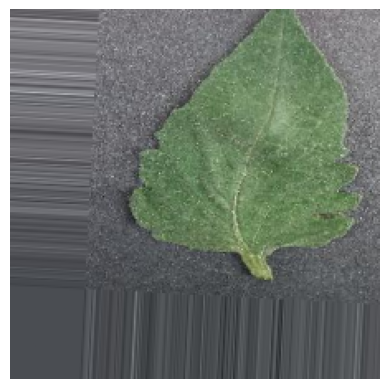

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('saved_models/mobilenet_finetuned_best.h5')

# Get class labels from the generator
class_labels = {v: k for k, v in val_generator.class_indices.items()}

# Get a random batch from val_generator
images, labels = next(val_generator)
random_index = np.random.randint(len(images))

# Select random image and its actual class
img = images[random_index]
actual_class_index = np.argmax(labels[random_index])
actual_class_name = class_labels[actual_class_index]

# Predict using the model
img_expanded = np.expand_dims(img, axis=0)
prediction = model.predict(img_expanded)
predicted_class_index = np.argmax(prediction)
predicted_class_name = class_labels[predicted_class_index]

# Display the image and prediction
plt.imshow(img)
plt.axis('off')
print(f"Actual Class: {actual_class_name}")
print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

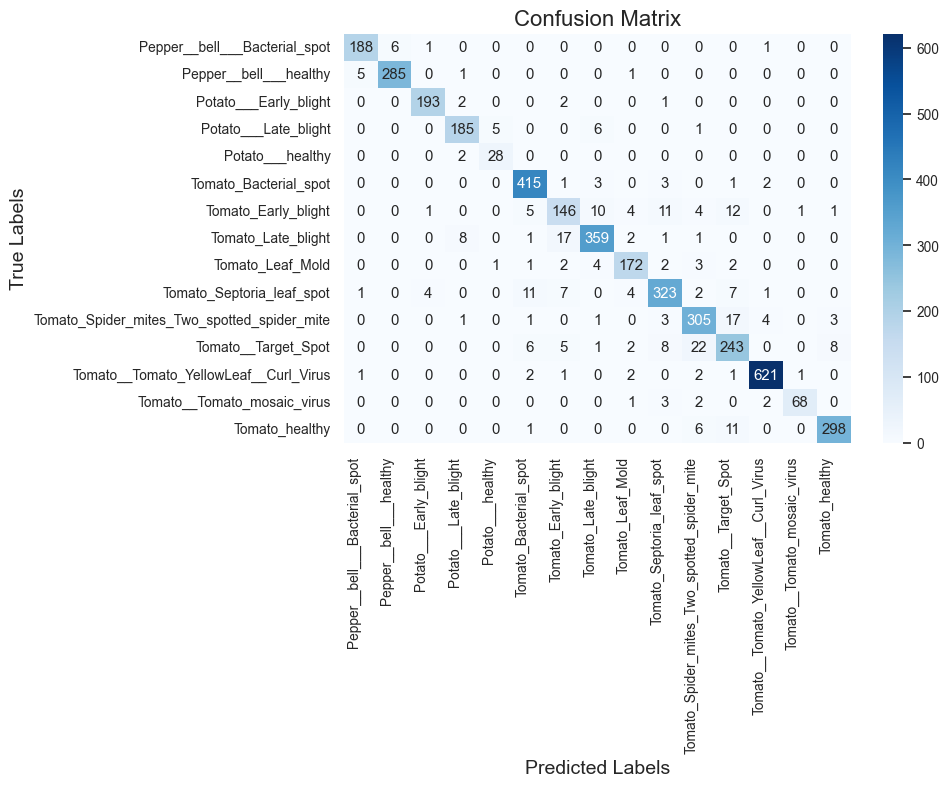


Accuracy: 0.9289

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.96      0.96      0.96       196
                     Pepper__bell___healthy       0.98      0.98      0.98       292
                      Potato___Early_blight       0.97      0.97      0.97       198
                       Potato___Late_blight       0.93      0.94      0.93       197
                           Potato___healthy       0.82      0.93      0.88        30
                      Tomato_Bacterial_spot       0.94      0.98      0.96       425
                        Tomato_Early_blight       0.81      0.75      0.78       195
                         Tomato_Late_blight       0.93      0.92      0.93       389
                           Tomato_Leaf_Mold       0.91      0.92      0.92       187
                  Tomato_Septoria_leaf_spot       0.91      0.90      0.90       360
Tomato_Spider_mites_Tw

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# Get class labels
class_labels = list(val_generator.class_indices.keys())

y_true = []
y_pred = []

for images, labels in val_generator:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))
    
    # Stop when all validation data is processed
    if len(y_true) >= val_generator.samples:
        break

conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


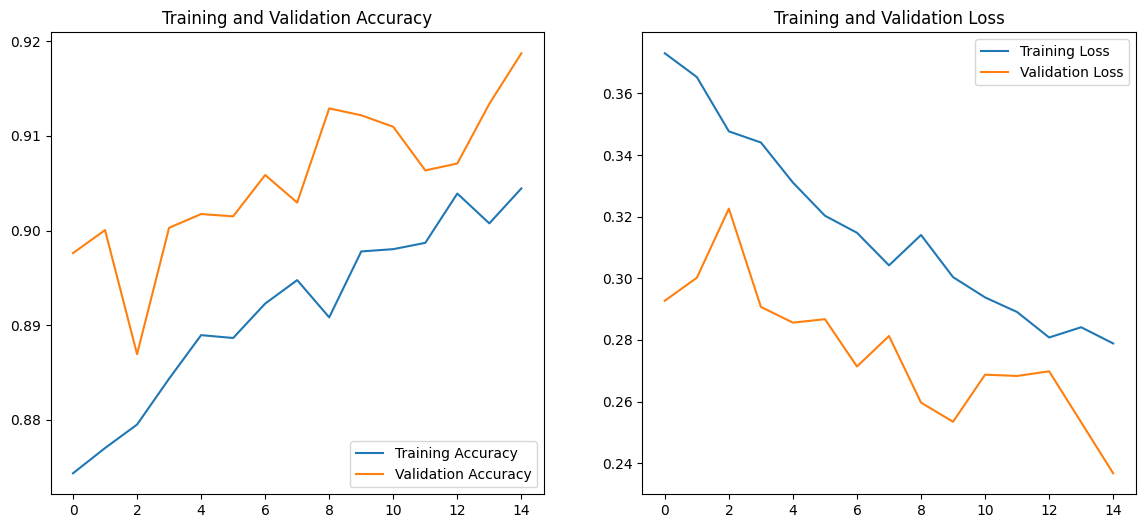

In [24]:
import matplotlib.pyplot as plt

# Combine both histories if needed
def plot_training_history(histories, titles):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    
    for h in histories:
        acc += h.history['accuracy']
        val_acc += h.history['val_accuracy']
        loss += h.history['loss']
        val_loss += h.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

# Plot
plot_training_history([history_fine], ["Fine-Tuning"])
